In [1]:
library(ggplot2)
library(plyr)
library(arules)
library(reshape2)

Warning message:
“replacing previous import ‘vctrs::data_frame’ by ‘tibble::data_frame’ when loading ‘dplyr’”
Loading required package: Matrix


Attaching package: ‘arules’


The following objects are masked from ‘package:base’:

    abbreviate, write




In [171]:
options(repr.plot.width=15, repr.plot.height=7, repr.plot.res = 150)

In [3]:
title_akas=read.delim('cleaned_filtered_title_akas.tsv')
merged=read.delim('../merge_basics_ratings_crew.tsv')

In [4]:
head(title_akas)
head(merged)

,titleId,region,isOriginalTitle
,<chr>,<chr>,<int>
1,tt0000001,UA,0
2,tt0000001,DE,0
3,tt0000001,HU,0
4,tt0000001,GR,0
5,tt0000001,RU,0
6,tt0000001,US,0


,tconst,titleType,isAdult,startYear,runtimeMinutes,genre1,genre2,genre3,averageRating,numVotes,n_directors,n_writers
,<chr>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<int>
1,tt0000001,short,0,1894,1,Documentary,Short,0,5.6,1654,1,1
2,tt0000002,short,0,1892,5,Animation,Short,0,6.1,199,1,1
3,tt0000003,short,0,1892,4,Animation,Comedy,Romance,6.5,1366,1,1
4,tt0000004,short,0,1892,12,Animation,Short,0,6.2,121,1,1
5,tt0000005,short,0,1893,1,Comedy,Short,0,6.2,2149,1,1
6,tt0000006,short,0,1894,1,Short,0,0,5.3,115,1,1


# Creating a new dataset 

In [5]:
freq=count(title_akas,'titleId') #Let's joint rows with the same titleId
names(freq)[names(freq) == "titleId"]="tconst" #And change the tiltleId name to tconst to perform a merge
new_merge=merge(freq,merged,by='tconst',all.x=T) #Merging
regions_success=new_merge[c('tconst','freq','averageRating','numVotes')] #Just want to analyze these attributes
regions_success=subset(regions_success,!is.na(averageRating) & averageRating>0,) #Just movies with ratings
regions_success=regions_success[order(regions_success$freq),] #Let's reorder the rows 

In [6]:
head(regions_success)

,tconst,freq,averageRating,numVotes
,<chr>,<int>,<dbl>,<int>
19,tt0000019,1,5.3,20
24,tt0000025,1,4.2,29
37,tt0000038,1,4.1,151
38,tt0000039,1,3.7,15
42,tt0000043,1,4.0,15
43,tt0000044,1,4.7,30


In [7]:
frequencies = unique(regions_success$freq)
means=c()
counts=c()

for (i in frequencies){
    means=append(means,mean(subset(regions_success,freq==i)$averageRating))
    counts=append(counts,nrow(subset(regions_success,freq==i)))
}

In [8]:
freq_ratings=data.frame(frequencies,means,counts)

In [9]:
#Discretizing the counts attribute for graphical purposes
freq_ratings$discrete=discretize(freq_ratings$counts, method = "cluster",breaks=20)

In [10]:
head(freq_ratings)

,frequencies,means,counts,discrete
,<int>,<dbl>,<int>,<fct>
1,1,6.603996,125618,"[8.72e+04,1.26e+05]"
2,2,6.249573,48803,"[3.68e+04,8.72e+04)"
3,3,6.134586,24741,"[1.98e+04,3.68e+04)"
4,4,6.095849,14863,"[1.19e+04,1.98e+04)"
5,5,6.085821,10163,"[6.99e+03,1.19e+04)"
6,6,6.038636,7581,"[6.99e+03,1.19e+04)"


# Making some plots

Warning message:
“Using alpha for a discrete variable is not advised.”
`geom_smooth()` using formula 'y ~ x'



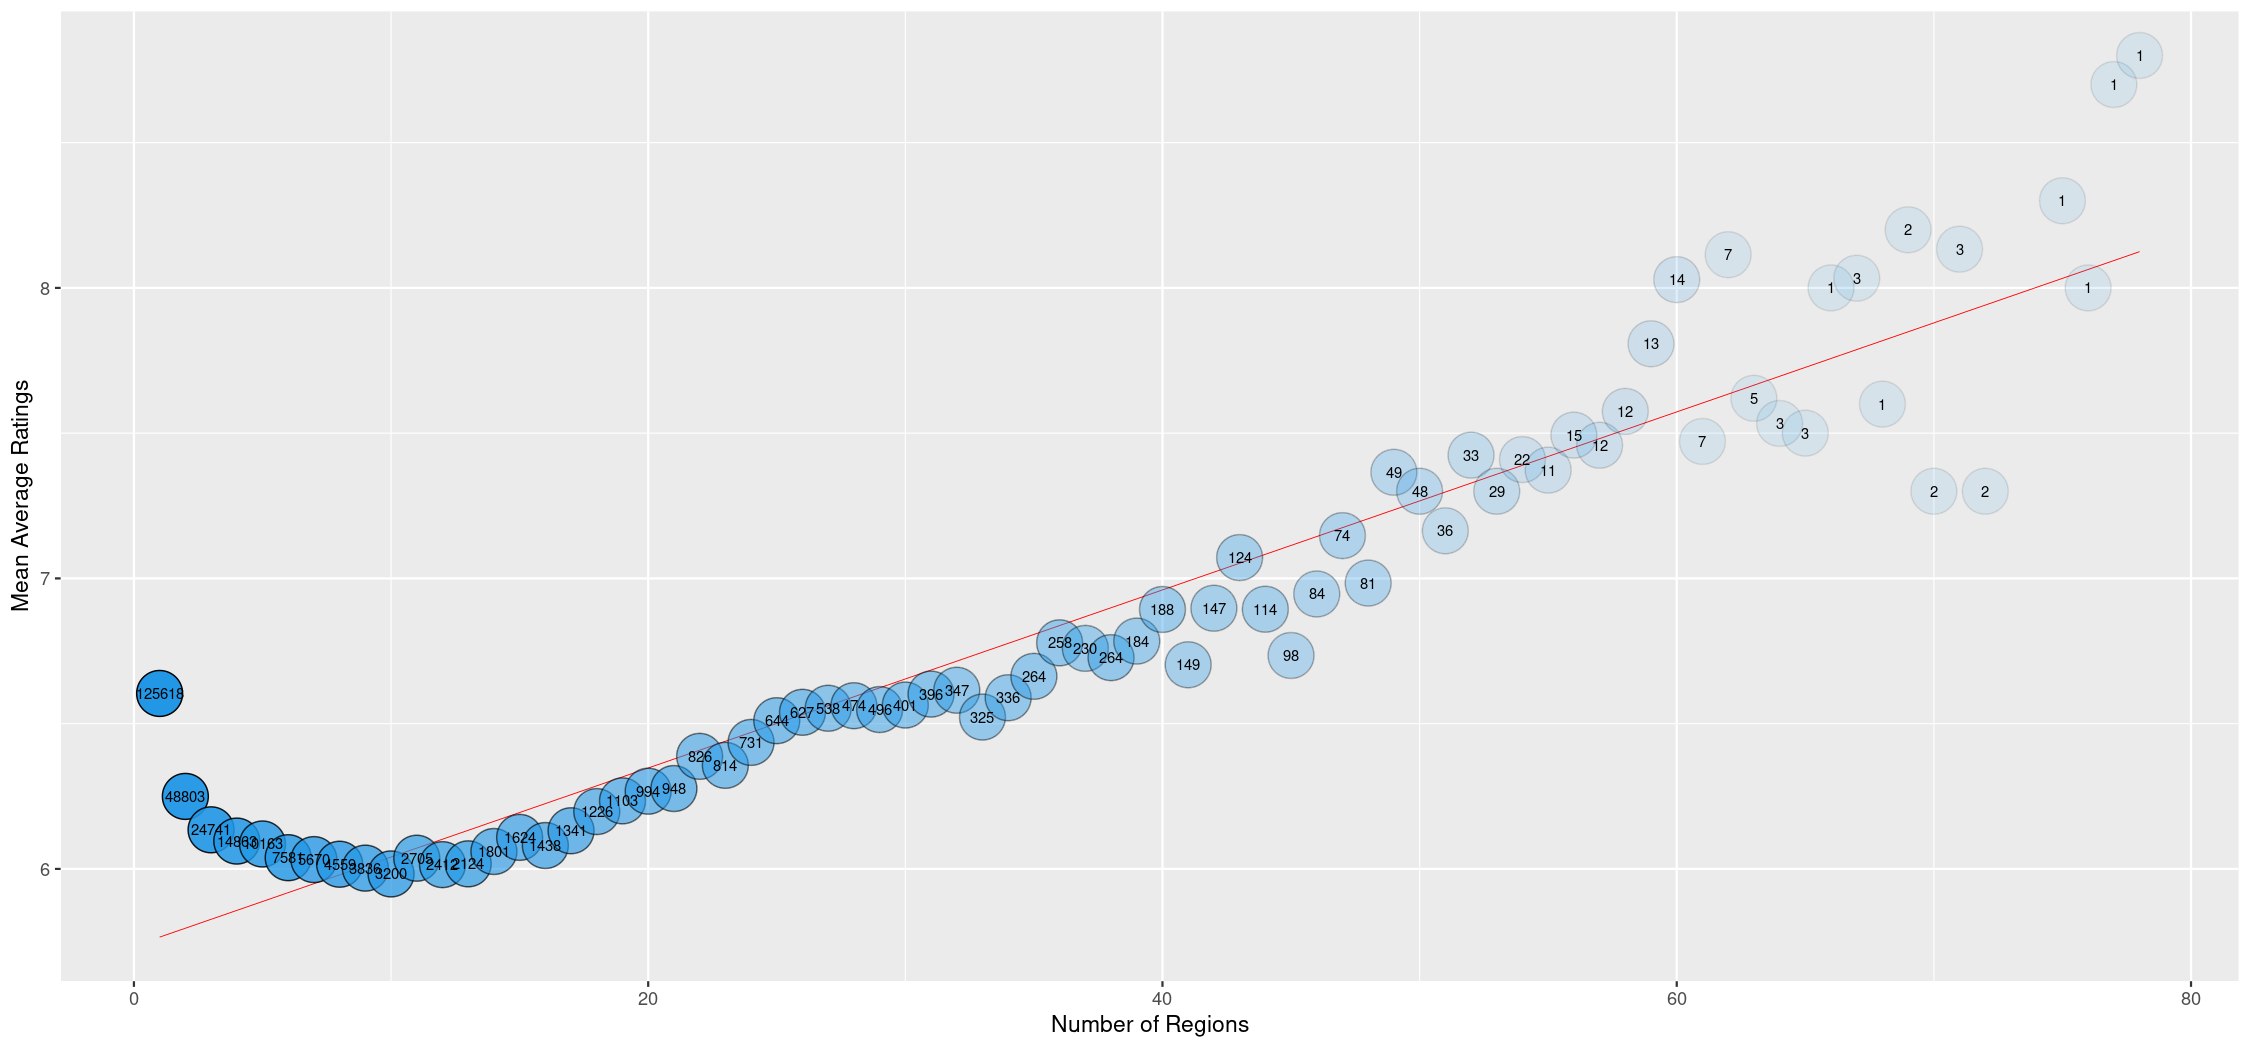

In [11]:
ggplot(freq_ratings,aes(x=frequencies,means))+
    stat_smooth(method=lm,se=F,col='red',size=.2)+
    geom_point(shape=21,size=10,fill=4,aes(alpha=discrete))+
    xlab('Number of Regions')+
    ylab('Mean Average Ratings')+
    geom_text(aes(label=paste(counts)),size=2.5)+
    theme(legend.position = "none")

In [12]:
# Very high correlation!
cor(freq_ratings$frequencies,freq_ratings$means,method='pearson')

[1] 0.941574

### In the previous scatter plot we can't really se what's happenning in the interval [1,39] in the x-axis. Let's zoom in

Warning message:
“Using alpha for a discrete variable is not advised.”
`geom_smooth()` using formula 'y ~ x'



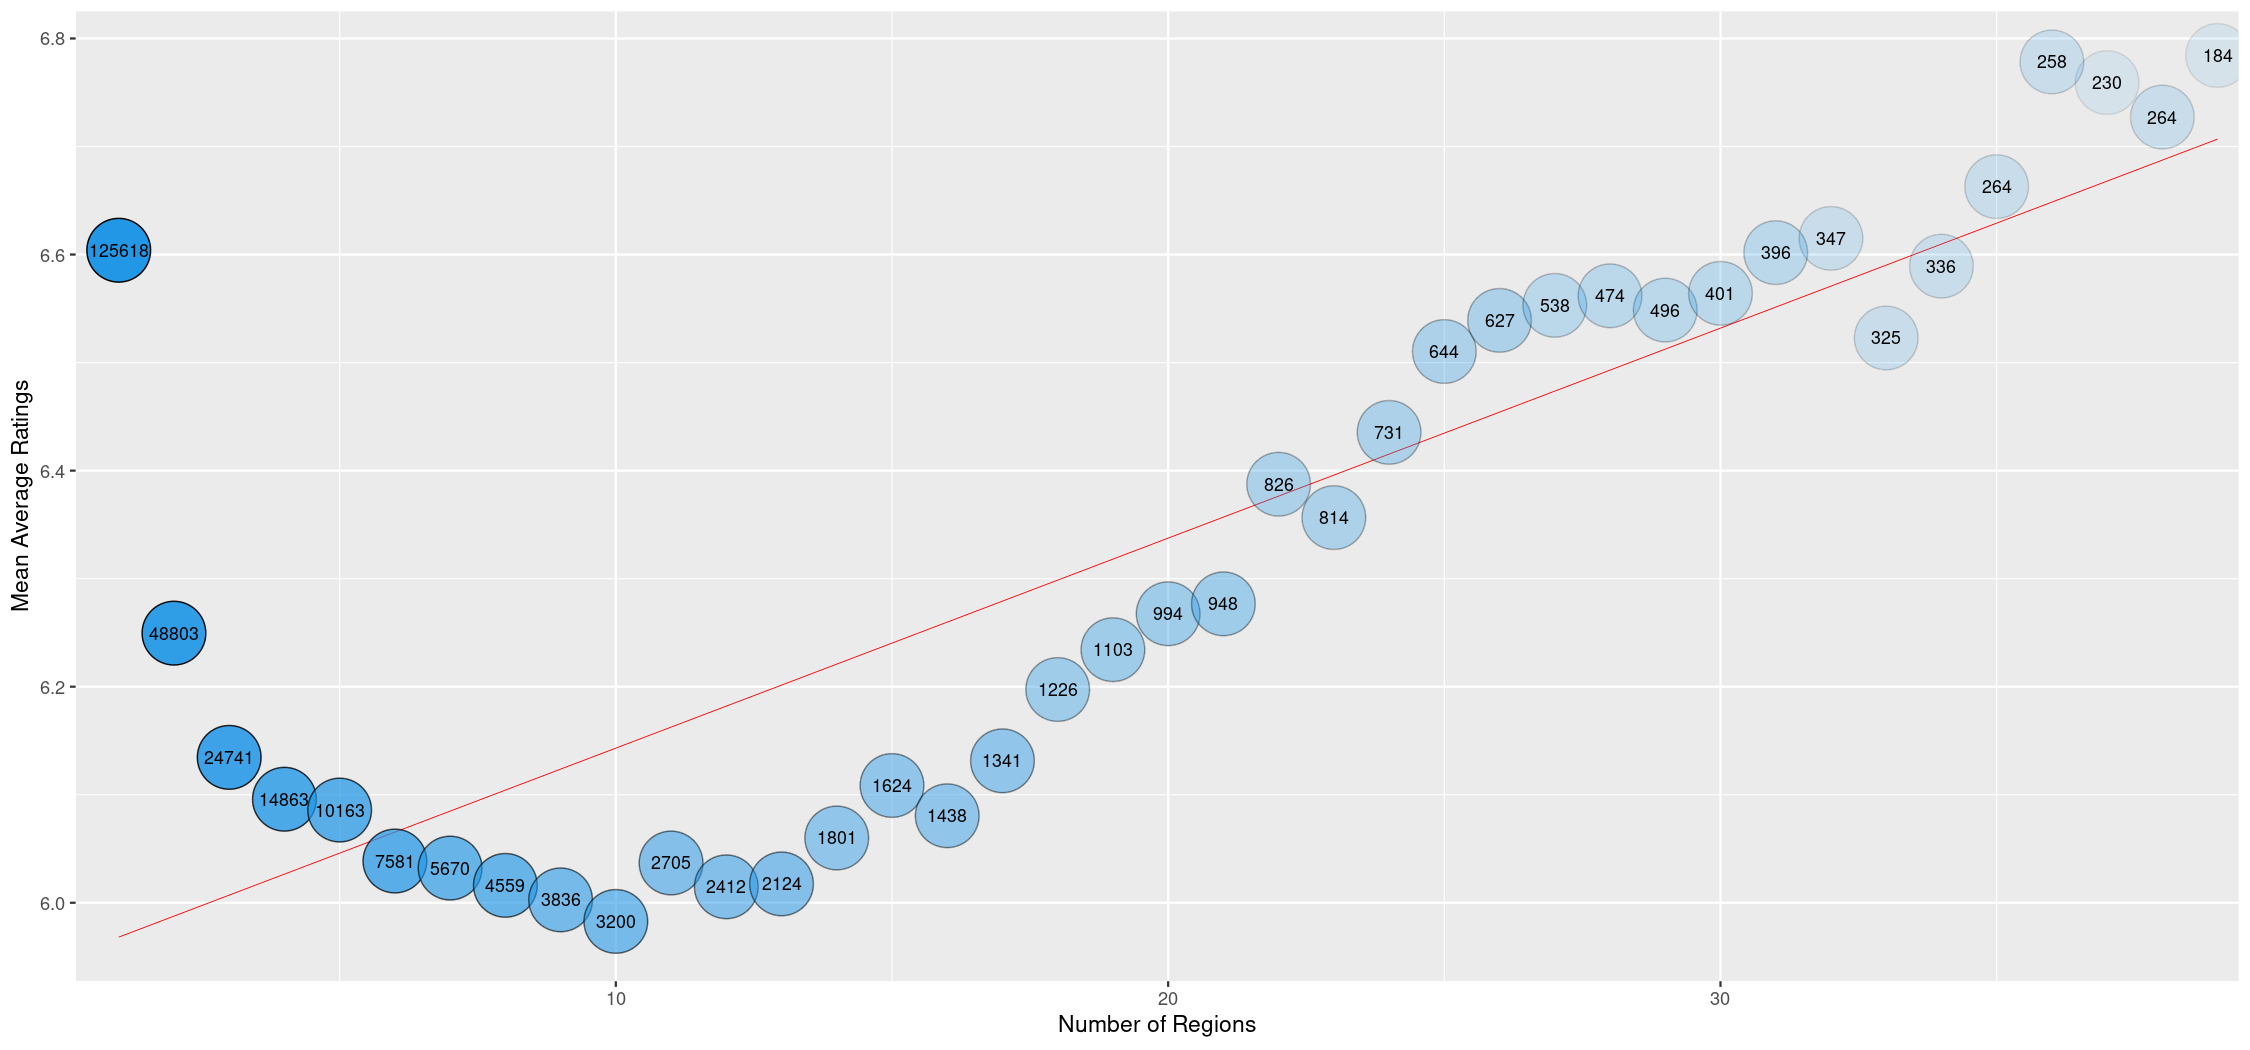

In [13]:
ggplot(freq_ratings[1:39,],aes(x=frequencies,means))+
    stat_smooth(method=lm,se=F,col='red',size=.2)+
    geom_point(shape=21,size=14,fill=4,aes(alpha=discrete))+
    xlab('Number of Regions')+
    ylab('Mean Average Ratings')+
    geom_text(aes(label=paste(counts)),size=3)+
    coord_cartesian(xlim=c(2,37.6))+
    #scale_alpha_manual(values=c(0.1, 0.2, .1),guide=F)
    #scale_alpha_continuous(range=c(0.1, 1),breaks=c(200,300,seq(0,3000,1000),10000,20000,40000))
    theme(legend.position = "none")

# Let's see some common characteristics of the movies which were translated to a certain number of region and the respetive mean average rating for that number of regions is 7 or above

In [14]:
f=subset(freq_ratings,means>=7)$frequencies

In [15]:
t=subset(new_merge,freq %in% f)

In [16]:
t[is.na(t$averageRating),] #It's just a movie, so let's remove it
t=t[!is.na(t$averageRating),]

,tconst,freq,titleType,isAdult,startYear,runtimeMinutes,genre1,genre2,genre3,averageRating,numVotes,n_directors,n_writers
,<chr>,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<int>
65115,tt0074084,43,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


In [17]:
head(t)

,tconst,freq,titleType,isAdult,startYear,runtimeMinutes,genre1,genre2,genre3,averageRating,numVotes,n_directors,n_writers
,<chr>,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<int>
13245,tt0013442,47,movie,0,1922,94,Fantasy,Horror,0,7.9,87420,1,2
15412,tt0015648,60,movie,0,1925,75,Drama,History,Thriller,8.0,52196,1,5
18189,tt0018455,43,movie,0,1927,94,Drama,Romance,0,8.1,46354,1,4
21405,tt0021749,54,movie,0,1931,87,Comedy,Drama,Romance,8.5,164387,1,3
21746,tt0022100,51,movie,0,1931,117,Crime,Mystery,Thriller,8.3,140732,1,3
22535,tt0022913,43,movie,0,1932,64,Drama,Horror,0,7.9,41495,1,6


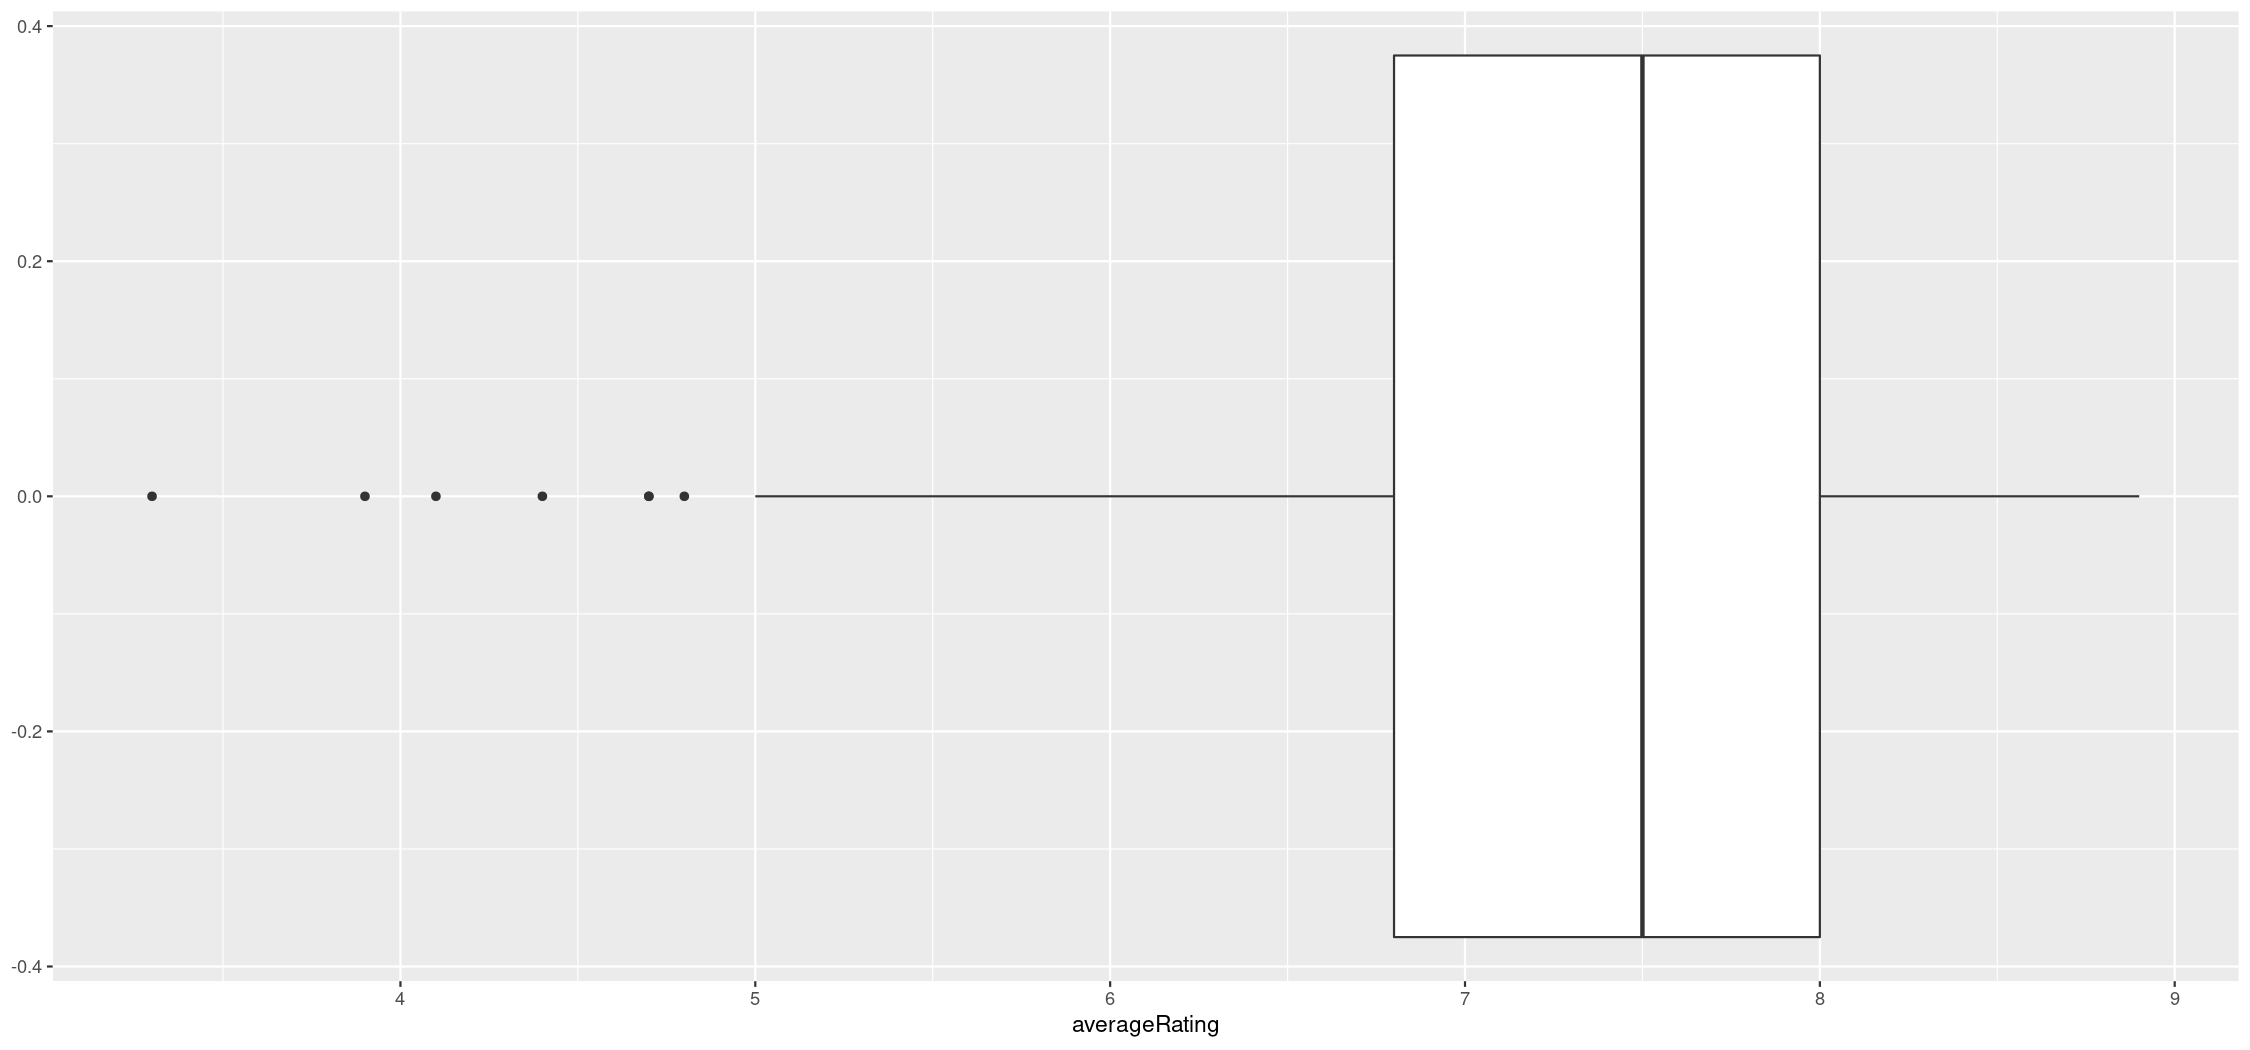

In [18]:
ggplot(t,aes(x=averageRating))+
    geom_boxplot()

Only 6 movies with ratings less than 5

# Let's see the genres - just genre1 and genre2

In [21]:
library(tidyverse)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ tibble  3.0.4     ✔ dplyr   1.0.0
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.0
✔ purrr   0.3.4     

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::arrange()   masks plyr::arrange()
✖ purrr::compact()   masks plyr::compact()
✖ dplyr::count()     masks plyr::count()
✖ tidyr::expand()    masks Matrix::expand()
✖ dplyr::failwith()  masks plyr::failwith()
✖ dplyr::filter()    masks stats::filter()
✖ dplyr::id()        masks plyr::id()
✖ dplyr::lag()       masks stats::lag()
✖ dplyr::mutate()    masks plyr::mutate()
✖ tidyr::pack()      masks Matrix::pack()
✖ dplyr::recode()    masks arules::recode()
✖ dplyr::rename()    masks plyr::rename()
✖ dplyr::summarise() masks plyr::summarise()
✖ dplyr::summarize() masks plyr::summarize()
✖ tidyr::unpack()    masks Matrix::unpack()



In [22]:
genres=t[,c(7,8)] #Just 2 genres

In [23]:
genres=table(interaction(genres)) #Creating a table with the interactions between genres
genres=melt(genres, value.name="count") #Converting the table into a dataframe
genres=subset(genres,count>0) #Some combinations of genres have 0 movies, which are useless
genres=separate(genres,'Var1',sep='[.]',into=c('genre1','genre2')) #Separating the Var1 column into 2 columns

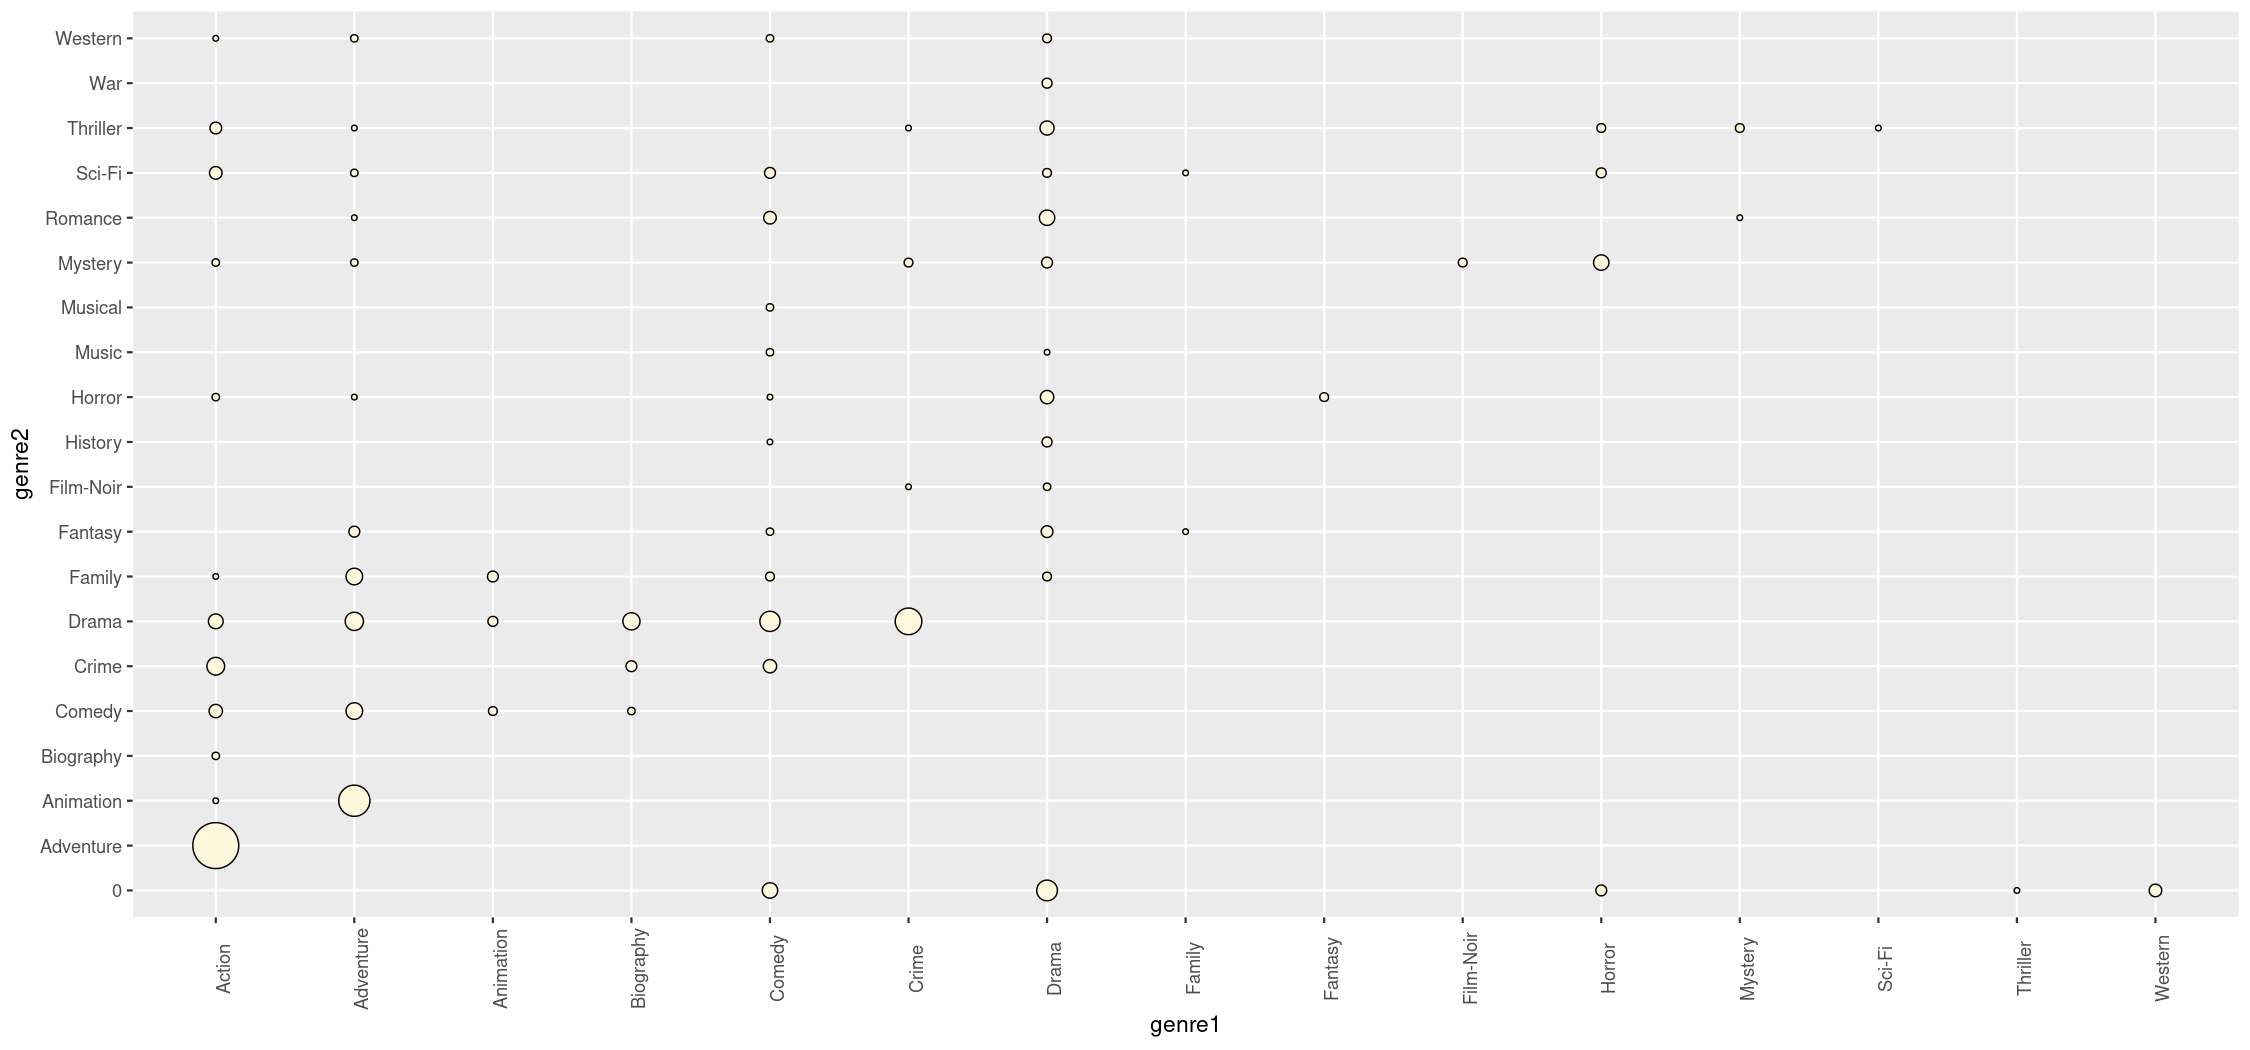

In [24]:
#Professsor's code - Notebook 10
ggplot(genres, aes(x=genre1, y=genre2)) +
    geom_point(aes(size=count), shape=21, color="black", fill="cornsilk") +
    scale_size_area(max_size=10, guide=FALSE) +
    theme(axis.text.x = element_text(angle = 90))

# Let's just see the ones with ratings above 7

In [25]:
t2=subset(t,averageRating>7)
genres2=t2[,c(7,8)] #Just 2 genres
genres2=table(interaction(genres2)) #Creating a table with the interactions between genres
genres2=melt(genres2, value.name="count") #Converting the table into a dataframe
genres2=subset(genres2,count>0) #Some combinations of genres have 0 movies, which are useless
genres2=separate(genres2,'Var1',sep='[.]',into=c('genre1','genre2')) #Separating the Var1 column into 2 columns

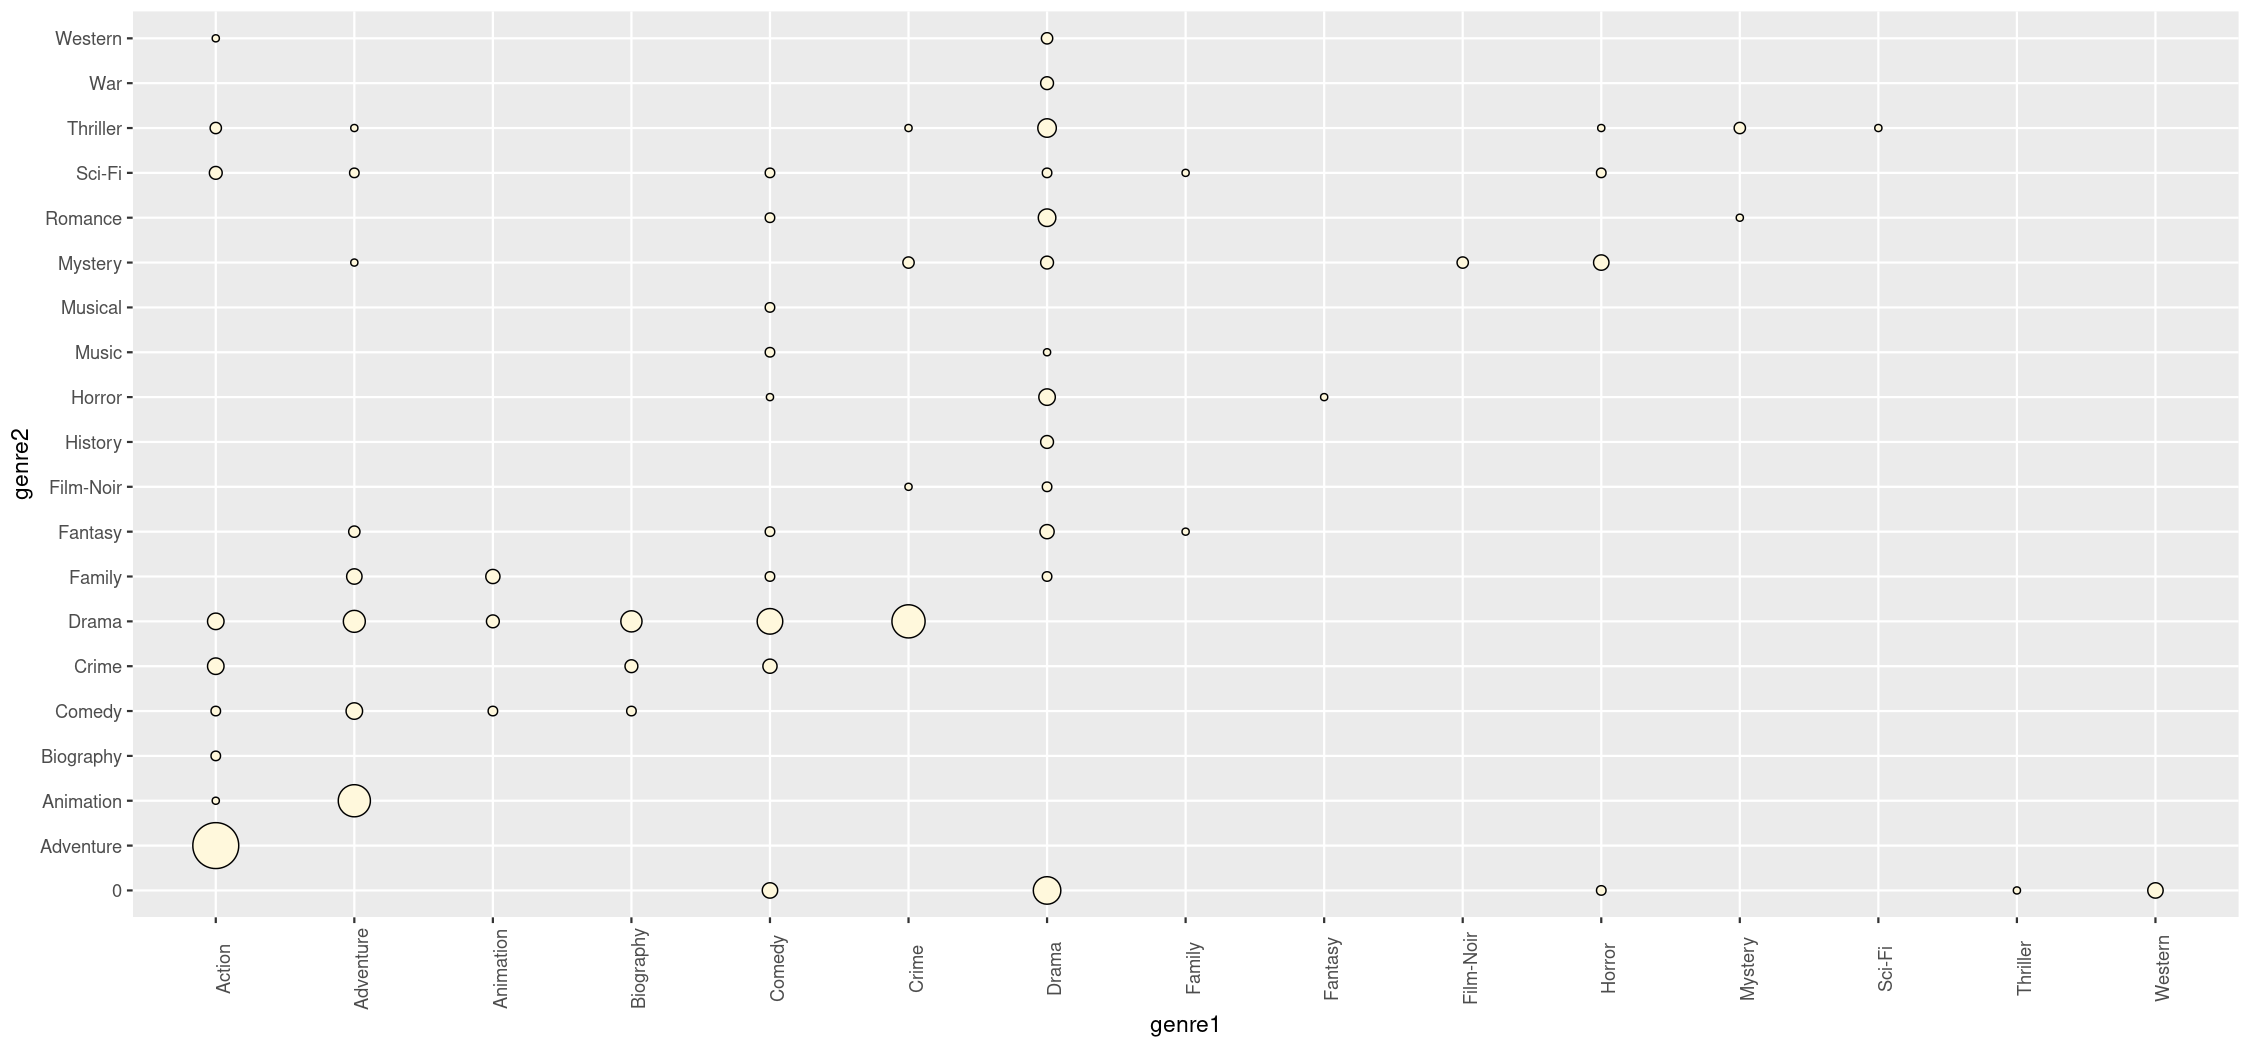

In [26]:
#Professsor's code - Notebook 10
ggplot(genres2, aes(x=genre1, y=genre2)) +
    geom_point(aes(size=count), shape=21, color="black", fill="cornsilk") +
    scale_size_area(max_size=10, guide=FALSE) +
    theme(axis.text.x = element_text(angle = 90))

The bigger circles are still the same: Action,Adventure ; Adventure,Animation; Crime,Drama and (just) Drama

# Looking at the 3 genres

In [97]:
three_genres=t[,c(7,8,9)]

In [98]:
three_genres=table(interaction(three_genres)) #Creating a table with the interactions between genres
three_genres=melt(three_genres, value.name="count") #Converting the table into a dataframe
three_genres=subset(three_genres,count>0) #Some combinations of genres have 0 movies, which are useless
three_genres=separate(three_genres,'Var1',sep='[.]',into=c('genre1','genre2','genre3')) #Separating the Var1 column into 2 columns

In [99]:
head(three_genres)

,genre1,genre2,genre3,count
,<chr>,<chr>,<chr>,<int>
5,Comedy,0,0,11
7,Drama,0,0,21
11,Horror,0,0,5
14,Thriller,0,0,1
15,Western,0,0,7
16,Action,Adventure,0,7


In [100]:
three_genres=three_genres[order(three_genres$count,decreasing=TRUE),]

In [102]:
head(three_genres)
#Favorite 3 genres combinations

,genre1,genre2,genre3,count
,<chr>,<chr>,<chr>,<int>
632,Adventure,Animation,Comedy,40
4216,Action,Adventure,Sci-Fi,28
7,Drama,0,0,21
4816,Action,Adventure,Thriller,16
1216,Action,Adventure,Drama,15
1816,Action,Adventure,Fantasy,14


# Looking at the titleType

In [109]:
t[t$titleType=='tvMovie',] #1 in this category
t[t$titleType=='short',] #0 in this category
#From the 535 row of the t dataset, 534 are movies

,tconst,freq,titleType,isAdult,startYear,runtimeMinutes,genre1,genre2,genre3,averageRating,numVotes,n_directors,n_writers
,<chr>,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<int>
68541,tt0079802,50,tvMovie,0,1980,98,Action,Adventure,Animation,5.7,3598,2,2


tconst,freq,titleType,isAdult,startYear,runtimeMinutes,genre1,genre2,genre3,averageRating,numVotes,n_directors,n_writers
<chr>,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<int>


[1] 535

# isAdult

In [114]:
t[t$isAdult==1,]
#All of them are non-adult movies

tconst,freq,titleType,isAdult,startYear,runtimeMinutes,genre1,genre2,genre3,averageRating,numVotes,n_directors,n_writers
<chr>,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<dbl>,<int>,<int>,<int>


# Runtime Minutes

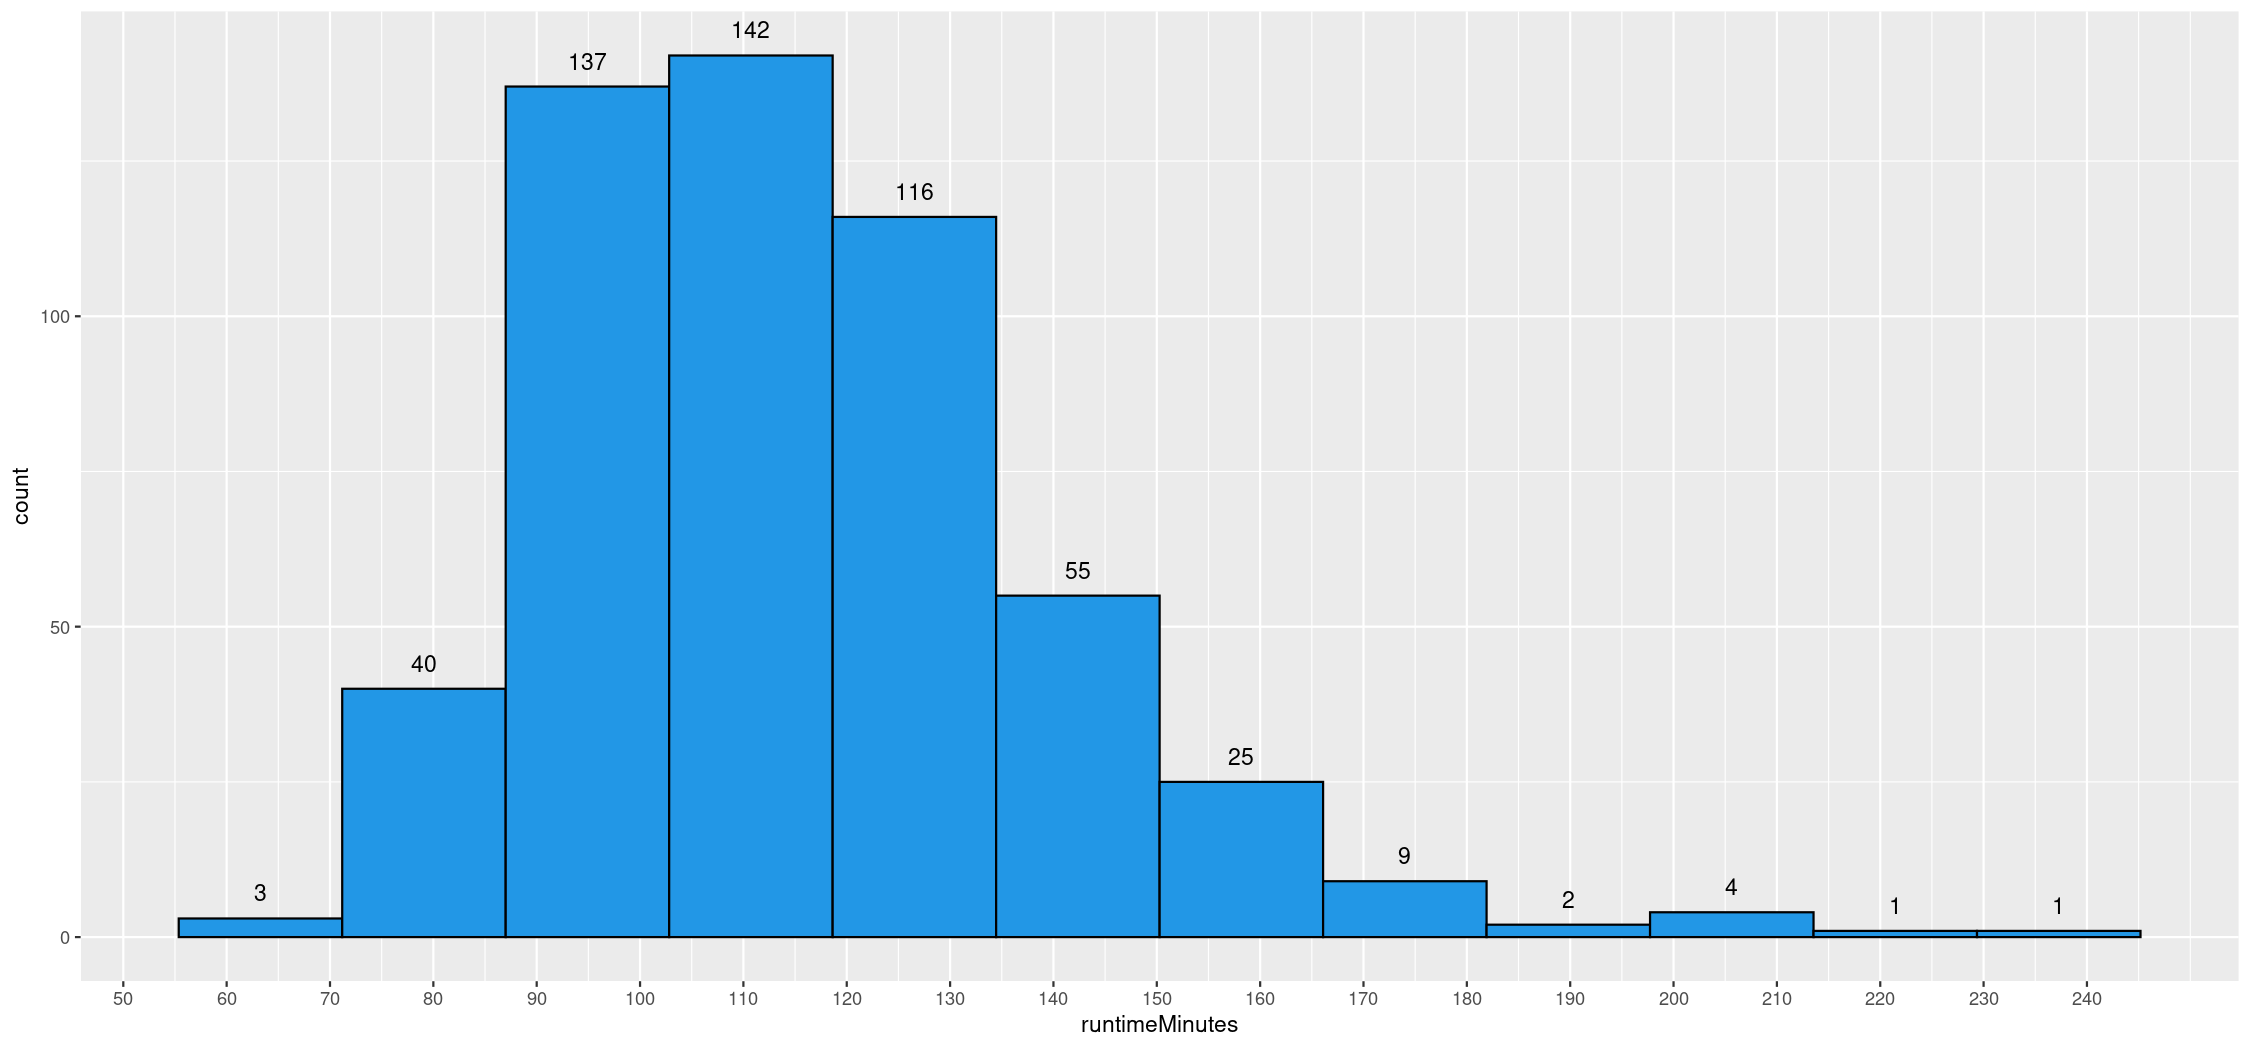

In [146]:
ggplot(t,aes(x=runtimeMinutes))+
    geom_histogram(bins=12,fill=4,col=1)+
    stat_bin(bins=12,geom="text", aes(label=..count..), vjust=-1) +
    scale_x_continuous(breaks=seq(50,240,10))

# StartYear

In [149]:
startYear_freq = t %>% count(startYear)

In [167]:
head(startYear_freq)

,startYear,n
,<int>,<int>
1,1922,1
2,1925,1
3,1927,1
4,1931,2
5,1932,2
6,1934,1


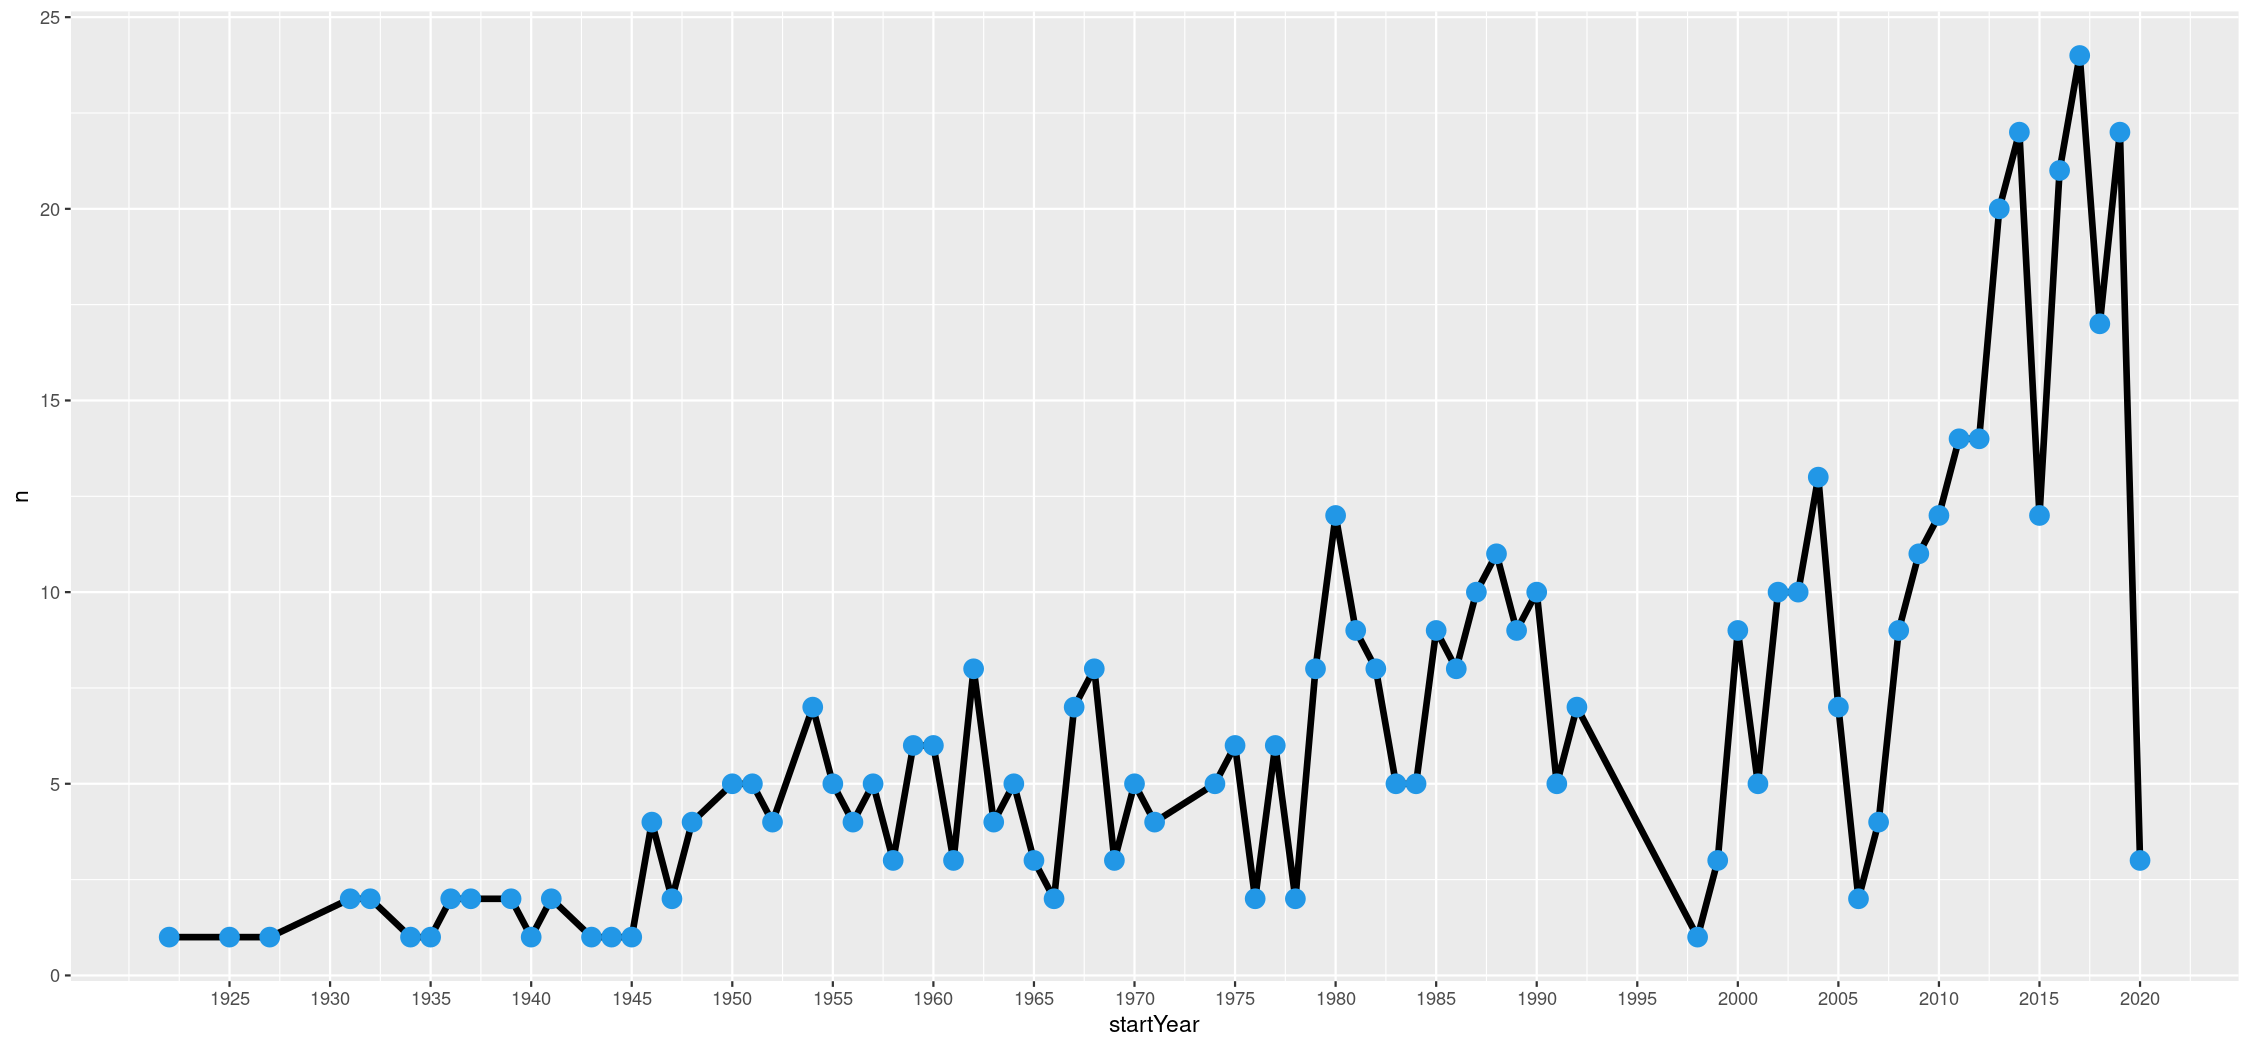

In [192]:
ggplot(startYear_freq,aes(y=n,x=startYear))+
    geom_line(size=1.5,col=9)+
    geom_point(shape=21,size=4,fill=4,col=4)+
    scale_x_continuous(breaks=seq(1925,2020,5))